In [40]:
import numpy as np
import h5py
from nbodykit.lab import *
import nbodykit 
import matplotlib.pyplot as plt
import scipy.integrate
import os
import pandas as pd

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
MEDIUM_SIZE = 30
SMALL_SIZE = 22
SSSMALL_SIZE = 16

plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)

In [4]:
def power_spectrum(filename, L_side=0):
    print(filename)
    f = h5py.File(filename, 'r')
    divergence = f['divergence'][...]
    f.close()

    cosmo = cosmology.Planck15    
    f = cosmo.scale_independent_growth_rate(0.0)
    
    delta = -divergence/(100 * cosmo.h)
        
    delta_mesh = nbodykit.source.mesh.array.ArrayMesh(delta, L_side) 
    r = FFTPower(delta_mesh, mode='1d', dk=3/L_side, kmin=0.005)
    Pk = r.power

    return {'k': Pk['k'], 'Pk':(Pk['power'].real- Pk.attrs['shotnoise'])}

In [29]:
def compute_power_spectra(ps_dict, path="./", name="nbody", 
                          vmax=None, lbox=1.0, nside=1, sigmas=[1]):
    experiment_name = "{}_{}_{}".format(name, lbox, nside)
    ps_dict[experiment_name] = {}
    ps_dict[experiment_name]["nside"] = nside
    ps_dict[experiment_name]["name"] = name
    ps_dict[experiment_name]["lbox"] = lbox
    ps_dict[experiment_name]["sigmas"] = sigmas
    
    for sigma in sigmas:
        if name=="nbody":
            filename = "velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_{:.1f}_sigma_{:.1f}_nside_{}.hdf5".format(vmax, sigma/2, nside)
        elif name=="gauss":
            filename = "mock_divergence_mesh_{}_box_{}_slim_{}.h5".format(nside, lbox, sigma)        
        filename = os.path.join(path, filename)
        print(experiment_name, sigma)
        ps_dict[experiment_name][sigma] = power_spectrum(filename, L_side=lbox)
    
    return

In [30]:
def corr_func(Pk, k):
    n_r = 1000
    r = np.linspace(0.1, 700.0, n_r)
    cf = np.zeros(n_r)
    for i in range(n_r):
        y = Pk[1:-1] * (k[1:-1]**2) * np.sin(k[1:-1]*r[i])/(k[1:-1]*r[i])
        x = k[1:-1]
        cf[i] = scipy.integrate.simps(y, x)
    cf = cf/(2.0*np.pi**2)
    
    i_min = np.argmin(np.abs(cf-cf[0]*0.2))
    half_r = r[i_min]
    #print(r[i_min])
    sigma_half_r = np.abs(r[i_min+1]-r[i_min-1])
    #sigma_half_r = 1.0
    print(cf[-1], cf[0], half_r)
    return {'cf':cf, 'r':r, 'half_r':half_r,'sigma_half_r':sigma_half_r}

In [31]:
data = {}

compute_power_spectra(data, path="./data/", 
                      name="gauss", sigmas=[2, 6, 10, 14, 20], nside=360, lbox=720)
compute_power_spectra(data, path="./data/", 
                      name="gauss", sigmas=[2, 6, 10, 14, 20], nside=256, lbox=320)
compute_power_spectra(data, path="./data/", 
                      name="gauss", sigmas=[2, 6, 10, 14, 20], nside=128, lbox=600)
compute_power_spectra(data, path="./data/", 
                      name="nbody", vmax=300, sigmas=[2, 6, 10, 14, 20], nside=360, lbox=720)


gauss_720_360 2
./data/mock_divergence_mesh_360_box_720_slim_2.h5
gauss_720_360 6
./data/mock_divergence_mesh_360_box_720_slim_6.h5
gauss_720_360 10
./data/mock_divergence_mesh_360_box_720_slim_10.h5
gauss_720_360 14
./data/mock_divergence_mesh_360_box_720_slim_14.h5
gauss_720_360 20
./data/mock_divergence_mesh_360_box_720_slim_20.h5
gauss_320_256 2
./data/mock_divergence_mesh_256_box_320_slim_2.h5
gauss_320_256 6
./data/mock_divergence_mesh_256_box_320_slim_6.h5
gauss_320_256 10
./data/mock_divergence_mesh_256_box_320_slim_10.h5
gauss_320_256 14
./data/mock_divergence_mesh_256_box_320_slim_14.h5
gauss_320_256 20
./data/mock_divergence_mesh_256_box_320_slim_20.h5
gauss_600_128 2
./data/mock_divergence_mesh_128_box_600_slim_2.h5
gauss_600_128 6
./data/mock_divergence_mesh_128_box_600_slim_6.h5
gauss_600_128 10
./data/mock_divergence_mesh_128_box_600_slim_10.h5
gauss_600_128 14
./data/mock_divergence_mesh_128_box_600_slim_14.h5
gauss_600_128 20
./data/mock_divergence_mesh_128_box_600_sli

In [32]:
for experiment in data.keys():
    print(experiment)
    x = data[experiment]
    for sigma in x['sigmas']:
        cf = corr_func(x[sigma]['Pk'], x[sigma]['k'])
        for c in cf.keys():
            data[experiment][sigma][c] = cf[c].copy()

gauss_720_360
1.3842844449370773e-06 0.45942347379853604 9.908408408408407
1.039068088878613e-05 0.10150169376294524 25.321621621621624
-4.027504789175349e-06 0.04101801473014868 39.33363363363363
-1.2726218670678244e-05 0.020254303352407348 53.34564564564565
2.2362633317821248e-05 0.009012843830674456 73.66306306306305
gauss_320_256
0.0003434228636073123 0.4536729954853174 9.908408408408407
9.809610234735457e-05 0.09743561076657639 24.621021021021022
0.0005395590456725479 0.03738423733409896 38.63303303303304
0.00031567339906642805 0.018881239734763317 49.842642642642645
0.00018834495344070295 0.007830857711813698 64.55525525525525
gauss_600_128
9.539241959827629e-05 0.46009218450887224 9.908408408408407
0.00010007497056910022 0.10114229324269296 25.321621621621624
3.775714811561574e-05 0.042224371825989794 38.63303303303304
0.0001288155717150306 0.02093995125877598 52.645045045045045
9.383505393086624e-05 0.009529084126821416 70.86066066066066
nbody_720_360
-6.277400130168842e-10 0.0

In [33]:
def plot_power_spectra(data, experiment_name):
    plt.figure(figsize=(9,7))
    sigmas = data[experiment_name]['sigmas']
    
    for i, sigma in enumerate(sigmas):
        plt.loglog(data[experiment_name][sigma]['k'], 
               data[experiment_name][sigma]['Pk'], 
               label="$R_s$={:d} Mpc $h^{{-1}}$".format(sigma),
               linewidth=i+1, color='black', alpha=0.5)

    if 'gauss' in experiment_name:
        exp_type = "Gaussian"
    else:
        exp_type = "N-body"
        
    # format the axes
    plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
    plt.ylabel(r"$P_{\delta}(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
    plt.legend(fontsize=SMALL_SIZE, loc=1)
    plt.xlim(1E-2, 1)
    is_nan = np.isnan(data[experiment_name][sigma]['Pk'])
    max_pk = np.max(data[experiment_name][sigma]['Pk'][~is_nan])
    plt.ylim(max_pk/1000,2*max_pk)
    plt.title(r"{},\ $L_b={},\ N_c={}$".format(
        exp_type, data[experiment_name]["lbox"], data[experiment_name]["nside"]))
    #plt.title(r"\verbatim{{}}".format(experiment_name))
    plt.savefig("power_spectrum_{}.pdf".format(experiment_name), bbox_inches='tight')

In [34]:
def plot_correlation_function(data, experiment_name):
    plt.figure(figsize=(9,7))
    sigmas = data[experiment_name]['sigmas']
    
    for i, sigma in enumerate(sigmas):
        plt.loglog(data[experiment_name][sigma]['r'], 
               data[experiment_name][sigma]['cf'], 
               label="$R_s$={:d} Mpc $h^{{-1}}$".format(sigma),
               linewidth=i+1, color='black', alpha=0.5)

    if 'gauss' in experiment_name:
        exp_type = "Gaussian"
    else:
        exp_type = "N-body"
        
    # format the axes
    plt.xlabel(r"$r$ [$\mathrm{Mpc}\ h^{-1}$]")
    plt.ylabel(r"$\xi_{\delta\delta}(r)$")
    plt.legend(fontsize=SMALL_SIZE, loc=1)
    plt.xlim(1.0, 2E2)
    y_max = np.max(data[experiment_name][sigmas[0]]['cf'])
    y_min = np.max(data[experiment_name][sigmas[-1]]['cf'])
    plt.ylim(y_min/10,1.5*y_max)
    plt.title(r"{},\ $L_b={},\ N_c={}$".format(
        exp_type, data[experiment_name]["lbox"], data[experiment_name]["nside"]))
    #plt.title(r"\verbatim{{}}".format(experiment_name))
    plt.savefig("corr_func_{}.pdf".format(experiment_name), bbox_inches='tight')

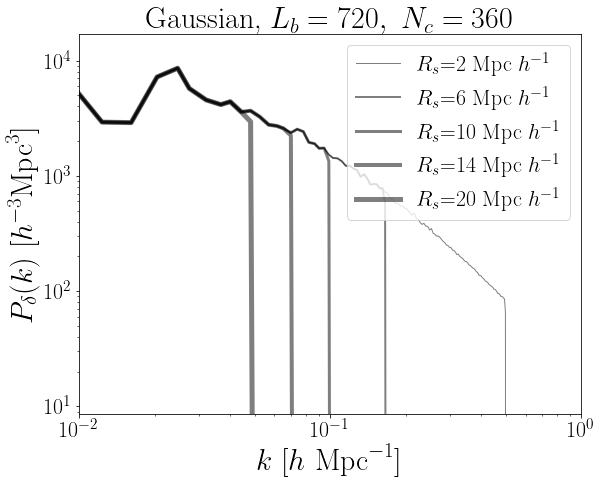

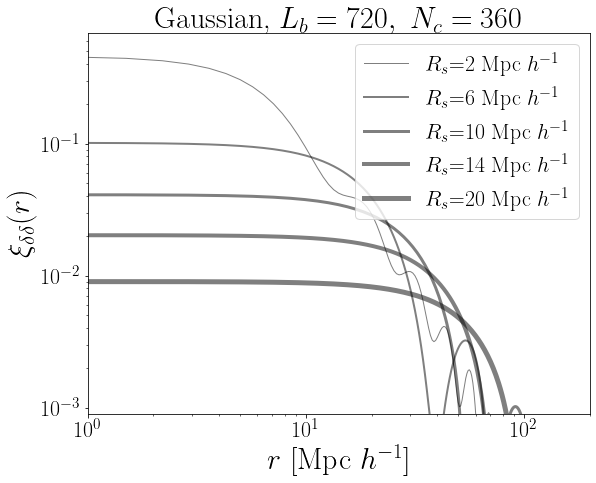

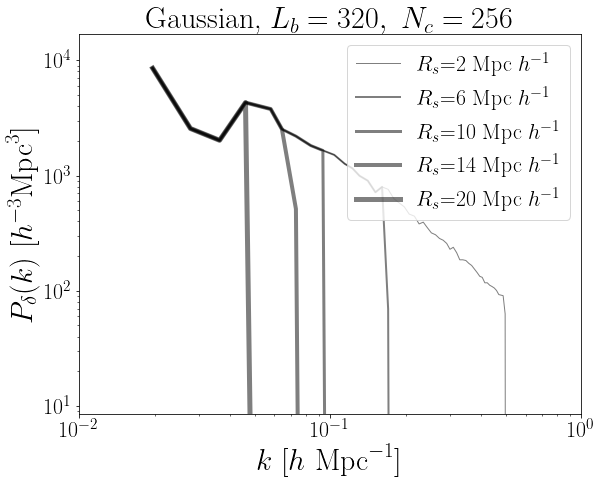

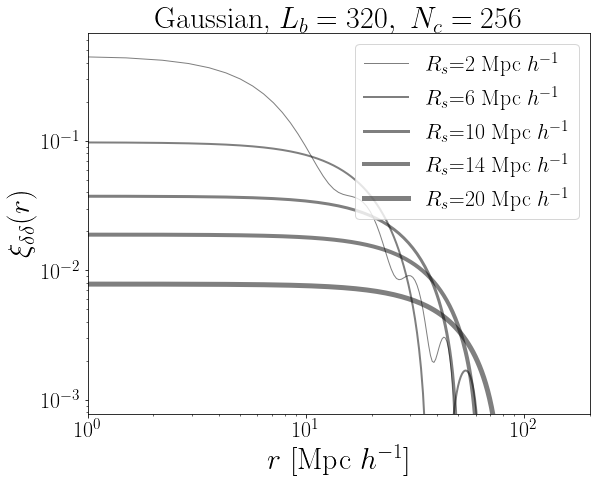

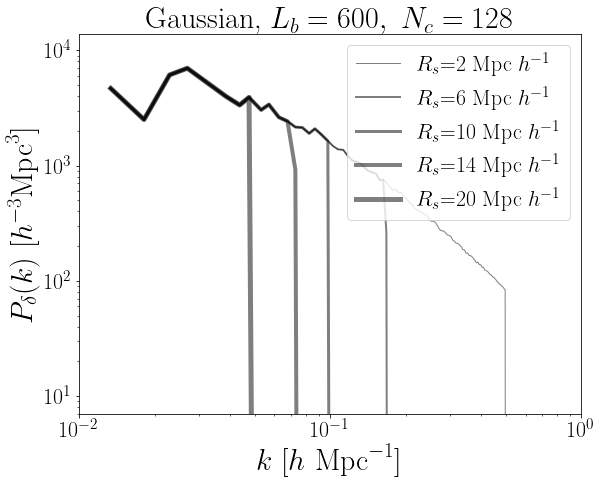

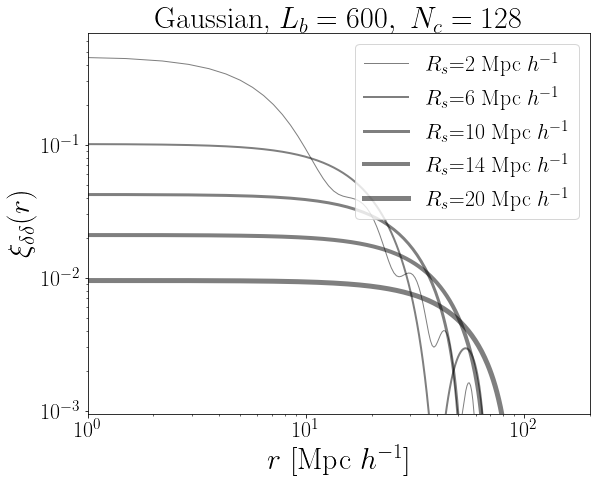

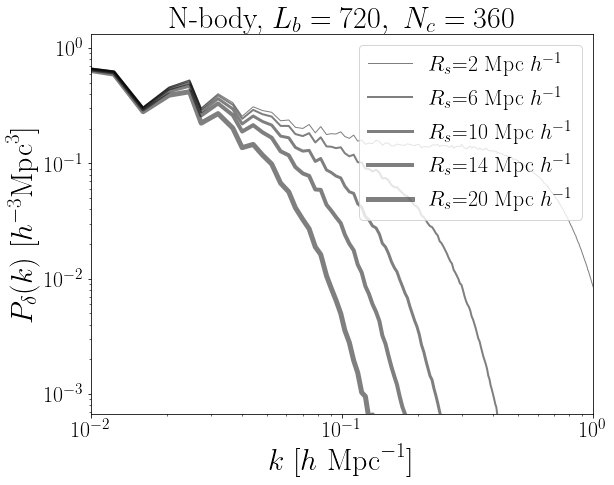

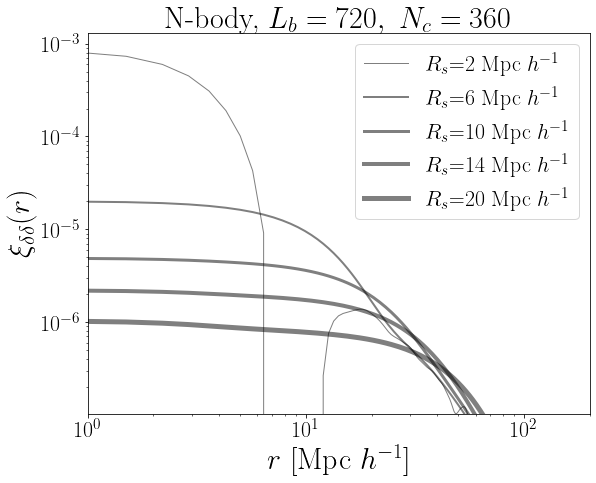

In [35]:
for experiment in data.keys():
    plot_power_spectra(data, experiment)
    plot_correlation_function(data, experiment)

In [36]:
def write_lengths(data, experiment):
    filename = "lengths_{}.dat".format(experiment)
    print(filename)
    f = open(filename, "w")
    for sigma in data[experiment]["sigmas"]:
        f.write("{} {:.2f} {} {}\n".format(sigma, data[experiment][sigma]['half_r'], 
                                       data[experiment]['lbox'], data[experiment]['nside']))    
    f.close()
    return filename

In [37]:
length_data = {}
for experiment in data.keys():
    filename = write_lengths(data, experiment)
    length_data[experiment] = np.loadtxt(filename)

lengths_gauss_720_360.dat
lengths_gauss_320_256.dat
lengths_gauss_600_128.dat
lengths_nbody_720_360.dat


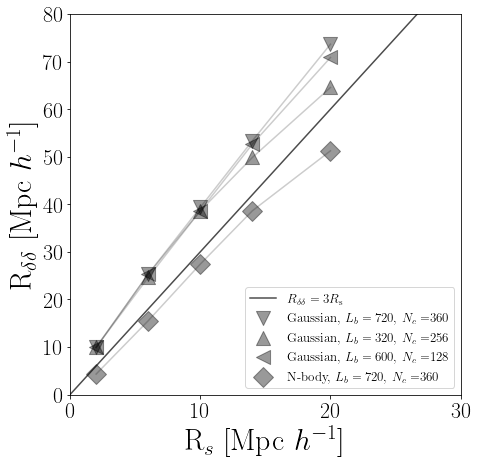

In [39]:
plt.figure(figsize=(7,7))

markers=["v", "^", "<", "D", "P", "X"]
for i, k in enumerate(length_data.keys()):
    lbox = data[k]["lbox"]
    nside = data[k]["nside"]
    if "gauss" in k:
        label = "Gaussian, $L_{b}=" + "{}$".format(lbox) + ",\ $N_{c}=$"+ "{}".format(nside)
    else:
        label = "N-body, $L_{b}=" + "{}$".format(lbox) + ",\ $N_{c}=$"+ "{}".format(nside)
        
    plt.scatter(length_data[k][:,0], length_data[k][:,1], marker=markers[i], 
                s=200, label=label, color='black', alpha=0.4)
    plt.plot(length_data[k][:,0], length_data[k][:,1], color='black', alpha=0.2)

x = np.linspace(0,140,100)
plt.plot(x, 3*x, 
         label=r'$R_{\delta\delta} = 3R_{\mathrm{s}}$', 
        color='black', alpha=0.7)
    
plt.xlim([0,30])
plt.ylim([0,80])
plt.legend(loc=4, fontsize=13)
plt.xlabel(r"R$_s$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.ylabel(r"R$_{\delta\delta}$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.savefig("correlation_length.pdf", bbox_inches='tight')

In [44]:
mean_radios = []
sigmas = [2,6,10,14,20]
mesh_box = [[360,720],[256,320],[128,600]]
gaussian = './data/R_eq_mock_mesh_{}_box_{}_slim_{}.csv'
nbodys = './data/R_eq_planck_0_v_max_300_sigma_{}.csv'
for i in mesh_box:
    radios_temp = []
    for j in sigmas:
        read = pd.read_csv(gaussian.format(i[0],i[1],j), dtype={"volumenes": np.float32})
        radios_temp.append(np.mean(np.array(read['volumenes'])))
    mean_radios.append(radios_temp)
radios_nbody = []
for i in sigmas:
    read = pd.read_csv(nbodys.format(int(i/2)), dtype={"volumenes": np.float32})
    radios_nbody.append(np.mean(np.array(read['volumenes'])))
mean_radios.append(radios_nbody)

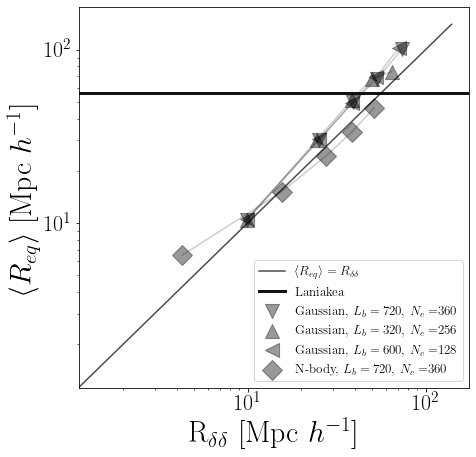

In [69]:
plt.figure(figsize=(7,7))

markers=["v", "^", "<", "D", "P", "X"]
for i, k in enumerate(length_data.keys()):
    lbox = data[k]["lbox"]
    nside = data[k]["nside"]
    if "gauss" in k:
        label = "Gaussian, $L_{b}=" + "{}$".format(lbox) + ",\ $N_{c}=$"+ "{}".format(nside)
    else:
        label = "N-body, $L_{b}=" + "{}$".format(lbox) + ",\ $N_{c}=$"+ "{}".format(nside)
        
    plt.scatter(length_data[k][:,1], mean_radios[i], marker=markers[i], 
                s=200, label=label, color='black', alpha=0.4)
    plt.plot(length_data[k][:,1], mean_radios[i], color='black', alpha=0.2)

x = np.linspace(0,140,100)
plt.plot(x, x, 
         label=r'$\left<R_{eq}\right> = R_{\delta\delta}$', 
        color='black', alpha=0.7)
plt.axhline(y=56, xmin = 0,xmax = 50,
         label='Laniakea', 
        color='black', alpha=20,lw = 3)
    
#plt.xlim([0,30])
#plt.ylim([0,80])
plt.legend(loc=4, fontsize=13)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"R$_{\delta\delta}$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.ylabel(r"$\left<R_{eq}\right>$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.savefig("mean_corr.pdf", bbox_inches='tight')